# Dataset transformation 

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
#from skimage.color import rgb2gray
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
#from torchvision import datasets, models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from PIL import Image

plt.ion()   # interactive mode

In [ ]:
#Get Train FILECLASSES
path = os.path.join('C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/train')
files = [os.path.join(i) for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
n = 0
train_landmarks_frame   = pd.DataFrame(files)
train_img_class = train_landmarks_frame[0].str[:1]
train_img_name = train_landmarks_frame.iloc[n, 0]
train_landmarks = train_landmarks_frame.iloc[n, 1:]
train_landmarks = np.asarray(train_landmarks)

In [ ]:
#Get Val FILECLASSES
path = os.path.join('C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/val')
files = [os.path.join(i) for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
n = 0
val_landmarks_frame   = pd.DataFrame(files)
val_img_class = val_landmarks_frame[0].str[:1]
val_img_name = val_landmarks_frame.iloc[n, 0]
val_landmarks = val_landmarks_frame.iloc[n, 1:]
val_landmarks = np.asarray(val_landmarks)


In [9]:
#Get test FILECLASSES
path = os.path.join('C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/test')
files = [os.path.join(i) for i in os.listdir(path) if os.path.isfile(os.path.join(path,i))]
n = 0
test_landmarks_frame   = pd.DataFrame(files)
test_img_class = test_landmarks_frame[0].str[:1]
test_img_name = test_landmarks_frame.iloc[n, 0]
test_landmarks = test_landmarks_frame.iloc[n, 1:]
test_landmarks = np.asarray(test_landmarks)

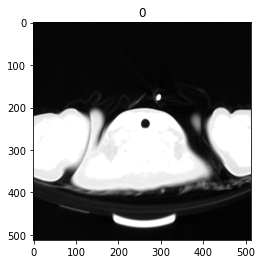

In [10]:
label = 0
def show_image(image, label):
    #img_class
    plt.title(label) 
    plt.imshow(image, cmap="gray")

plt.figure()
show_image(io.imread(os.path.join('C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/test', val_img_name)),
              label )
plt.show()

In [11]:
class CTScansDataset(Dataset):
    """CT Scans dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
      
        #image = io.imread(img_name)
        #image = io.imread(img_name, as_gray=True)
        image = Image.open(img_name)
        image = image.convert('RGB')
        label  = int(self.landmarks_frame.iloc[idx,0][0])
   
        #sample = {'image': image, 'label': label}
        #sample = {torch.tensor(image,label)}
        #sample = {torch.tensor(img), torch.tensor(label)}
        sample = {'image': np.asarray(image), 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
   

In [ ]:
train_dataset = CTScansDataset(csv_file=train_landmarks_frame,
                                      root_dir='C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/train')

val_dataset = CTScansDataset(csv_file=val_landmarks_frame,
                                      root_dir='C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/val')



In [12]:
test_dataset = CTScansDataset(csv_file=test_landmarks_frame,
                                      root_dir='C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/test')

In [13]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        # mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224
        # https://pytorch.org/hub/pytorch_vision_resnet/

        return {'image': img, 'label': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        #landmarks = landmarks - [left, top]

        return {'image': image, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        #image = image.to(torch.float32)
        
        return {'image': torch.from_numpy(image),
                'label': torch.as_tensor(np.array(label).astype('float'))}

In [ ]:
trans_train_dataset = CTScansDataset(csv_file=train_landmarks_frame,
                                            root_dir='C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/train',
                                           transform=transforms.Compose([
                                               Rescale(224),
                                               #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                               #RandomCrop(224),
                                               ToTensor()
                                           ]))

trans_val_dataset = CTScansDataset(csv_file=val_landmarks_frame,
                                            root_dir='C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/val',
                                           transform=transforms.Compose([
                                               Rescale(224),
                                               #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                               #RandomCrop(224),
                                               ToTensor()
                                           ]))



In [14]:
trans_test_dataset = CTScansDataset(csv_file=test_landmarks_frame,
                                            root_dir='C:/Users/tkaczmarski/OneDrive - HCAI/Desktop/praca mgr/datasets/cncb_ncov/test',
                                           transform=transforms.Compose([
                                               Rescale(224),
                                               #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                               #RandomCrop(224),
                                               ToTensor()
                                           ]))


In [ ]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_image(**transformed_sample)

plt.show()

In [ ]:
#Pickling cause error ValueError: I/O operation on closed file.

In [ ]:
trainlist = []
for i in trans_train_dataset:
    sample = i['image'], i['label']
    trainlist.append(sample)


In [ ]:
torch.save(trainlist, 'trainlist.pt')


In [ ]:
vallist = []
for i in trans_val_dataset:
    sample = i['image'], i['label']
    vallist.append(sample)
    #15min?


In [ ]:
torch.save(vallist, 'vallist.pt')
#15:28

In [ ]:
testlist = []
for i in trans_test_dataset:
    sample = i['image'], i['label']
    testlist.append(sample)
    #15min?

In [ ]:
torch.save(testlist, 'testlist.pt')